In [96]:

import pandas as pd
import numpy as np
import re
import string
import nltk
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [97]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     D:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [98]:
stop_words = set(stopwords.words('english'))
domain_words = {
    "airport","klia","staff","malaysia","malaysian","flight","terminal","gate","counter",
    "immigration","airline","airlines","plane","arrival","departure","queue","checkin",
    "baggage","luggage"
}
stop_words.update(domain_words)

In [99]:
lemmatizer = WordNetLemmatizer()

In [100]:
def get_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def preprocess(text):
    if not isinstance(text, str):
        return ""
    # Handle encoding issues
    text = text.encode('latin1', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower().translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(tok, get_pos(tag))
        for tok, tag in tagged
        if tok not in stop_words
    ]
    return " ".join(lemmas)

In [101]:
df = pd.read_csv("training_data.csv")  # replace with your dataset filename
df['clean_text'] = df['TEXT'].apply(preprocess)

In [102]:
#TF-IDF Vectorixer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])
y = df['SENTIMENT']

In [103]:
# Train/ test spliy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [104]:
# Train SVM MODEL

svm = LinearSVC(class_weight='balanced', max_iter=5000)
svm.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


In [105]:
y_pred = svm.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:

              precision    recall  f1-score   support

    Negative     0.9103    0.9199    0.9151       287
     Neutral     0.7647    0.3939    0.5200        33
    Positive     0.8578    0.9141    0.8851       198

    accuracy                         0.8842       518
   macro avg     0.8443    0.7426    0.7734       518
weighted avg     0.8810    0.8842    0.8784       518



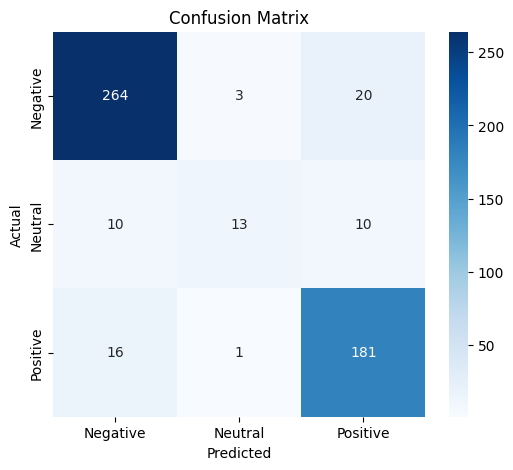

In [106]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=svm.classes_, yticklabels=svm.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [107]:
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(svm, "svm_model_3class.pkl")

['svm_model_3class.pkl']

In [108]:
unlabeled_df = pd.read_csv("unlabeled_real_data.csv")  # Column: TEXT
unlabeled_df['clean_text'] = unlabeled_df['TEXT'].apply(preprocess)

X_unlabeled = tfidf.transform(unlabeled_df['clean_text'])
unlabeled_pred = svm.predict(X_unlabeled)

# Optional: compute confidence as softmax over decision function
from scipy.special import softmax
decision = svm.decision_function(X_unlabeled)
if len(decision.shape)==1:
    probs = np.vstack([1-softmax(decision), softmax(decision)]).T
else:
    probs = softmax(decision, axis=1)

unlabeled_df['PREDICTION'] = unlabeled_pred
unlabeled_df['CONFIDENCE_%'] = np.max(probs, axis=1)*100

unlabeled_df.to_csv("unlabeled_predictions.csv", index=False)
print("Saved predictions to unlabeled_predictions.csv")

Saved predictions to unlabeled_predictions.csv
